# Préparation des données

In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier


from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import joblib

warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg



In [2]:
num_rows = 10000
df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau


prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev


pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos


ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins


cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc


train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)
train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

del df

f_score = dict()
lim = dict()
feats = [f for f in train_df.columns if f not in [
    'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
np.savetxt("feats.csv", np.atleast_2d(feats), fmt="%s", delimiter=",")


test_df.to_pickle("test_df.gz", compression={
                  'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Previous applications df shape: (9734, 242)
Pos-cash balance df shape: (9494, 15)
Installments payments df shape: (8893, 26)
Credit card balance df shape: (9520, 131)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Essais sur les algorithmes

In [3]:
#Permet de produire la courbe du fbeta score
def fbscore (X, y, beta = 1):
    
    pre, rec, thresh = precision_recall_curve(X, y)
    pre = pre[:-1]
    rec = rec[:-1]
    
    b2 = beta**2
    temp = pd.DataFrame(pre, columns=["pre"])
    temp["rec"] = rec
    temp["fb"] = ((1 + b2)*(temp["pre"] * temp["rec"]))/(b2 * temp["pre"] + temp["rec"])
    temp["fb"].fillna(0, inplace=True)
    fb = temp["fb"].to_numpy()
    
    return fb, thresh

# D'après la courbe du fbeta score, classe les éléments dans une ou l'autre catégorie selon la 
# probabilité correspondant au fbeta score maximal
def classifier (target, fbtab, thresh):
    lim = thresh[np.argmax(fbtab)]
    tab_class = (target > lim).astype(int)
    return tab_class, lim

In [4]:
# met en forme les parametres de sortie du grid-search du pipeline pour être compatible avec l'algorithme 
def best_params(gs):
    dic = gs.best_params_
    a = list(dic.keys())
    temp = pd.Series(list(dic.keys()))
    b = temp.str.split("__").str[1].to_numpy()
    for i in range(len(a)):
        dic[b[i]] = dic.pop(a[i])
    return dic

In [5]:
def lightgbm(num_folds, beta = 1, grid_search = True):
    
    
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    if grid_search :
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = LGBMClassifier()
        steps = [("over", over), ("under", under), ("model", clf)]
        LGBM_pipe = Pipeline(steps=steps)

        params = [{"model__n_estimators" : [100, 1000, 10000],
                  "model__learning_rate" : [0.001, 0.01, 0.1], 
                  "model__num_leaves" : [20, 30, 40]}]

        gs_LGBM = GridSearchCV(LGBM_pipe,
                              param_grid = params,
                               scoring = "roc_auc",
                               cv=5)

        gs_LGBM.fit(train_df[feats], train_df['TARGET'])
        params = best_params(gs_LGBM)
        print(params)
    else :
        params = {'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 20}
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.3)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = LGBMClassifier(**params)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y, model__eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            model__eval_metric= "auc", model__verbose= 200, model__early_stopping_rounds= 200)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += pipeline.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        


        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        

        
        del clf, train_x, train_y, valid_x, valid_y, pipeline
        
    fb_lgbm, thresh = fbscore(train_df["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    test_df["TARGET LGBM"], lim["LGBM"] = classifier(sub_preds, fb_lgbm, thresh)
    test_df["TARGET LGBM score"] = sub_preds
    
  
    return feature_importance_df, np.max(fb_lgbm), oof_preds, params


In [6]:
def RF_classifier(num_folds, beta = 1, grid_search = True):
    
    print("Starting Random Forest. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    if grid_search :
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = RandomForestClassifier()
        steps = [("over", over), ("under", under), ("model", clf)]
        RF_pipe = Pipeline(steps=steps)

        params = [{"model__n_estimators" : [10, 100, 1000],
                  "model__max_features" : ["sqrt", "log2"], 
                  "model__n_jobs" : [6]}]

        gs_RF = GridSearchCV(RF_pipe,
                              param_grid = params,
                               scoring = "roc_auc",
                               cv=5)

        gs_RF.fit(train_df[feats], train_df['TARGET'])
        params = best_params(gs_RF)
        print(params)
    else :
        params = {'max_features': 'sqrt', 'n_estimators': 1000, 'n_jobs': 6}
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = RandomForestClassifier(**params)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x)[:, 1]
        sub_preds += pipeline.predict_proba(test_df[feats])[:, 1] / folds.n_splits
        


        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        

        
        del clf, pipeline, train_x, train_y, valid_x, valid_y
        
    fb_lgbm, thresh = fbscore(train_df["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    test_df["TARGET RF"], lim["RF"] = classifier(sub_preds, fb_lgbm, thresh)
   
    return feature_importance_df, np.max(fb_lgbm)


In [7]:
def KNN(num_folds, beta = 1, grid_search = False):
    
    print("Starting KNN. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    if grid_search :
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = KNeighborsClassifier()
        steps = [("over", over), ("under", under), ("model", clf)]
        RF_pipe = Pipeline(steps=steps)

        params = [{"model__n_neighbors" : [4, 5, 6, 7, 8, 9],
                  "model__algorithm" : ["ball_tree", "kd_tree"], 
                  "model__n_jobs" : [6]}]

        gs_RF = GridSearchCV(RF_pipe,
                              param_grid = params,
                               scoring = "roc_auc",
                               cv=5)

        gs_RF.fit(train_df[feats], train_df['TARGET'])
        params = best_params(gs_RF)
        print(params)
    else :
        params = {'algorithm': 'kd_tree', 'n_jobs': 6, 'n_neighbors': 9}
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.1)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = KNeighborsClassifier(**params)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x)[:, 1]
        sub_preds += pipeline.predict_proba(test_df[feats])[:, 1] / folds.n_splits      

        
        del clf, train_x, train_y, valid_x, valid_y, pipeline
        
    fb_lgbm, thresh = fbscore(train_df["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    test_df["TARGET KNN"], lim["KNN"] = classifier(sub_preds, fb_lgbm, thresh)
   
    return np.max(fb_lgbm)


In [8]:
def Linear(num_folds, beta = 1):
    
    print("Starting Logistic Regression. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = LogisticRegression(n_jobs = 6, max_iter = 5000)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x)[:, 1]
        sub_preds += pipeline.predict_proba(test_df[feats])[:, 1] / folds.n_splits      

        
        del clf, train_x, train_y, valid_x, valid_y, pipeline
        
    fb_lgbm, thresh = fbscore(train_df["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    test_df["TARGET Linear"], lim["Linear"] = classifier(sub_preds, fb_lgbm, thresh)
   
    return np.max(fb_lgbm)


In [33]:
feature_imp_lgbm, f_score["LGBM"], pred_train, params_lgbm = lightgbm(
    num_folds = 6, beta = 0.1, grid_search=False)

Starting LightGBM. Train shape: (10000, 768), test shape: (10000, 773)


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.821862	valid_0's binary_logloss: 0.286542	valid_1's auc: 0.764621	valid_1's binary_logloss: 0.303296


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.82858	valid_0's binary_logloss: 0.284538	valid_1's auc: 0.723973	valid_1's binary_logloss: 0.312541
[400]	valid_0's auc: 0.889195	valid_0's binary_logloss: 0.230246	valid_1's auc: 0.744803	valid_1's binary_logloss: 0.278048
[600]	valid_0's auc: 0.932123	valid_0's binary_logloss: 0.199929	valid_1's auc: 0.742773	valid_1's binary_logloss: 0.270153


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.823911	valid_0's binary_logloss: 0.287176	valid_1's auc: 0.762916	valid_1's binary_logloss: 0.300115
[400]	valid_0's auc: 0.886612	valid_0's binary_logloss: 0.232971	valid_1's auc: 0.777727	valid_1's binary_logloss: 0.264384
[600]	valid_0's auc: 0.930515	valid_0's binary_logloss: 0.201724	valid_1's auc: 0.780219	valid_1's binary_logloss: 0.254192
[800]	valid_0's auc: 0.957169	valid_0's binary_logloss: 0.180071	valid_1's auc: 0.778896	valid_1's binary_logloss: 0.25069


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.819026	valid_0's binary_logloss: 0.287981	valid_1's auc: 0.74662	valid_1's binary_logloss: 0.29912
[400]	valid_0's auc: 0.885157	valid_0's binary_logloss: 0.234581	valid_1's auc: 0.757183	valid_1's binary_logloss: 0.264464
[600]	valid_0's auc: 0.931794	valid_0's binary_logloss: 0.203377	valid_1's auc: 0.762796	valid_1's binary_logloss: 0.253444
[800]	valid_0's auc: 0.957742	valid_0's binary_logloss: 0.181697	valid_1's auc: 0.764	valid_1's binary_logloss: 0.249668
[1000]	valid_0's auc: 0.97347	valid_0's binary_logloss: 0.163896	valid_1's auc: 0.762589	valid_1's binary_logloss: 0.247874


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.83147	valid_0's binary_logloss: 0.285151	valid_1's auc: 0.701362	valid_1's binary_logloss: 0.316861
[400]	valid_0's auc: 0.890899	valid_0's binary_logloss: 0.228124	valid_1's auc: 0.704269	valid_1's binary_logloss: 0.28583
[600]	valid_0's auc: 0.93182	valid_0's binary_logloss: 0.197856	valid_1's auc: 0.702581	valid_1's binary_logloss: 0.280291


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	valid_0's auc: 0.830007	valid_0's binary_logloss: 0.29096	valid_1's auc: 0.698813	valid_1's binary_logloss: 0.297487
[400]	valid_0's auc: 0.891577	valid_0's binary_logloss: 0.234247	valid_1's auc: 0.726769	valid_1's binary_logloss: 0.257468
[600]	valid_0's auc: 0.931615	valid_0's binary_logloss: 0.204357	valid_1's auc: 0.727916	valid_1's binary_logloss: 0.247911
[800]	valid_0's auc: 0.956186	valid_0's binary_logloss: 0.183139	valid_1's auc: 0.729947	valid_1's binary_logloss: 0.244423
F-0.1 score max : 0.380235294117647


In [37]:
test_df["TARGET LGBM"].value_counts()

0    9976
1      24
Name: TARGET LGBM, dtype: int64

Text(0.5, 1.0, 'Credit acceptation repartition')

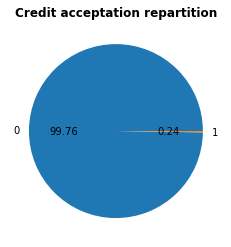

In [36]:
plt.figure()
plt.pie(test_df["TARGET LGBM"].value_counts(), 
        labels=test_df["TARGET LGBM"].value_counts().index, 
        autopct="%.2f")
plt.title("Credit acceptation repartition", weight="bold")

In [34]:
feature_imp_rf, f_score["RF"] = RF_classifier(num_folds = 6, beta = 0.1, grid_search=False)

Starting Random Forest. Train shape: (10000, 768), test shape: (10000, 773)
F-0.1 score max : 0.36


In [38]:
test_df["TARGET RF"].value_counts()

0    9958
1      42
Name: TARGET RF, dtype: int64

In [14]:
f_score["KNN"] = KNN(num_folds = 6, beta = 0.1, grid_search=False)

Starting KNN. Train shape: (10000, 768), test shape: (10000, 771)
F-0.1 score max : 0.11542857142857141


In [15]:
test_df["TARGET KNN"].value_counts()

0    10000
Name: TARGET KNN, dtype: int64

In [16]:
f_score["Linear"] = Linear(num_folds = 6, beta = 0.1)

Starting Logistic Regression. Train shape: (10000, 768), test shape: (10000, 772)
F-0.1 score max : 0.18805778491171748


In [17]:
test_df["TARGET Linear"].value_counts()

0    9877
1     123
Name: TARGET Linear, dtype: int64

# Resultats et préparation à l'API

Text(0.5, 1.0, "fbeta score selon l'algorithme")

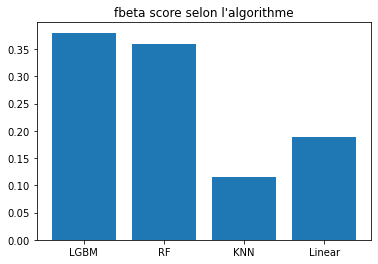

In [39]:
plt.bar(f_score.keys(), f_score.values())
plt.title("fbeta score selon l'algorithme")

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresh2 = roc_curve(train_df["TARGET"], pred_train)
auc = roc_auc_score(train_df["TARGET"], pred_train)

In [20]:
fbres, thresh = fbscore(train_df["TARGET"], pred_train, 0.1)
prec, rec, _ = precision_recall_curve(train_df["TARGET"], pred_train)

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


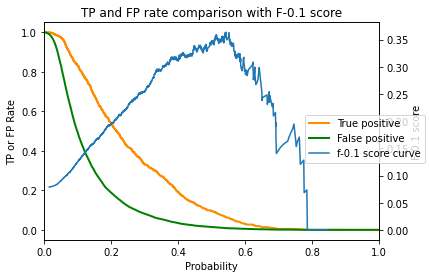

In [21]:
fig, ax1 = plt.subplots()
lw = 2
ax1.plot(
    thresh2,
    tpr,
    color="darkorange",
    lw=lw,
    label="True positive" % auc,
)
ax1.plot(
    thresh2,
    fpr,
    color="green",
    lw=lw,
    label="False positive" % auc,
)

ax1.set_xlabel("Probability")
ax1.set_ylabel("TP or FP Rate")
ax1.set_xlim([0,1])

ax2 = ax1.twinx()
ax2.plot(
    thresh,
    fbres,
    label="f-0.1 score curve")
ax2.set_ylabel("F-0.1 score")


ax1.set_title("TP and FP rate comparison with F-0.1 score")
fig.legend(loc="right")
fig.show()

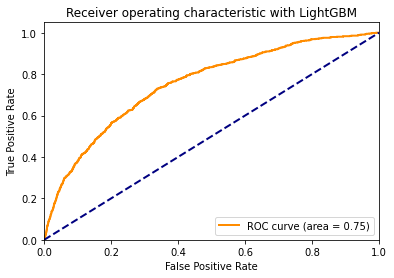

In [22]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with LightGBM")
plt.legend(loc="lower right")
plt.show()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


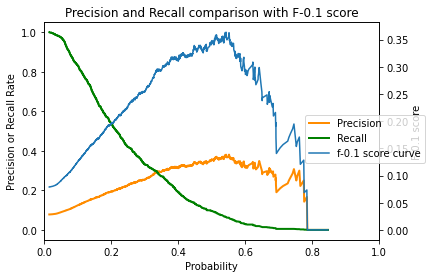

In [23]:
fig, ax1 = plt.subplots()
lw = 2
ax1.plot(
    thresh,
    prec[:-1],
    color="darkorange",
    lw=lw,
    label="Precision" % auc,
)
ax1.plot(
    thresh,
    rec[:-1],
    color="green",
    lw=lw,
    label="Recall" % auc,
)

ax1.set_xlabel("Probability")
ax1.set_ylabel("Precision or Recall Rate")
ax1.set_xlim([0,1])

ax2 = ax1.twinx()
ax2.plot(
    thresh,
    fbres,
    label="f-0.1 score curve")
ax2.set_ylabel("F-0.1 score")


ax1.set_title("Precision and Recall comparison with F-0.1 score")
fig.legend(loc="right")
fig.show()

In [40]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy = 0.5)
clf = LGBMClassifier(**params_lgbm)

steps = [("over", over), ("under", under), ("model", clf)]
pipeline = Pipeline(steps=steps)

pipeline.fit(train_df[feats], train_df["TARGET"])





Pipeline(steps=[('over', SMOTE(sampling_strategy=0.2)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 LGBMClassifier(learning_rate=0.01, n_estimators=1000,
                                num_leaves=20))])

In [42]:
fi = pd.DataFrame()

In [43]:
fi["importances"] = clf.feature_importances_

In [44]:
fi["features"] = feats

In [49]:
fi.sort_values(by=["importances"], ascending=False, inplace=True)

La figure ci-après représente les feature importances définies par LightGBM.

Text(0.5, 1.0, 'local feature importances')

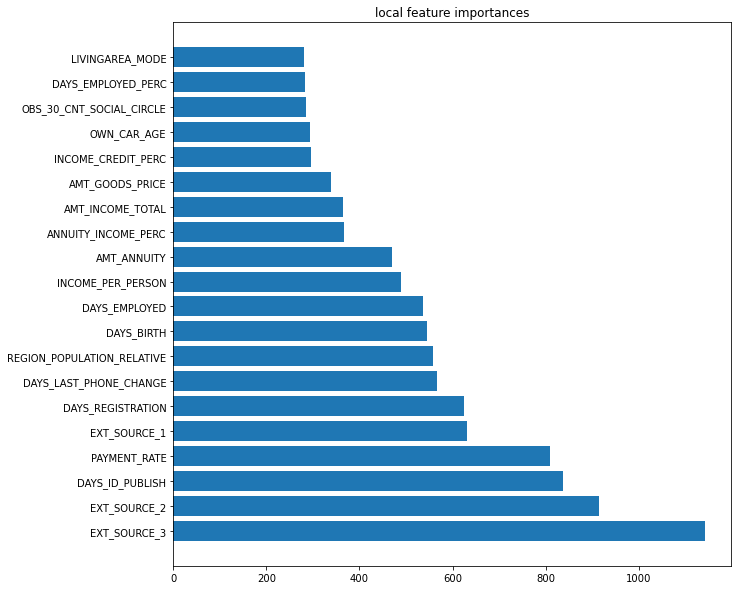

In [53]:
fig = plt.figure(figsize=(10,10))
plt.barh(fi["features"][:20], fi["importances"][:20])
plt.title("local feature importances")

In [25]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf)
joblib.dump(explainer, "shap_explainer.joblib")

['shap_explainer.joblib']

In [26]:
shap_values = explainer.shap_values(test_df[feats])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


La figure ci-après présente les features importances calculées par Shap, donc indépendante de l'algorithme utilisé.

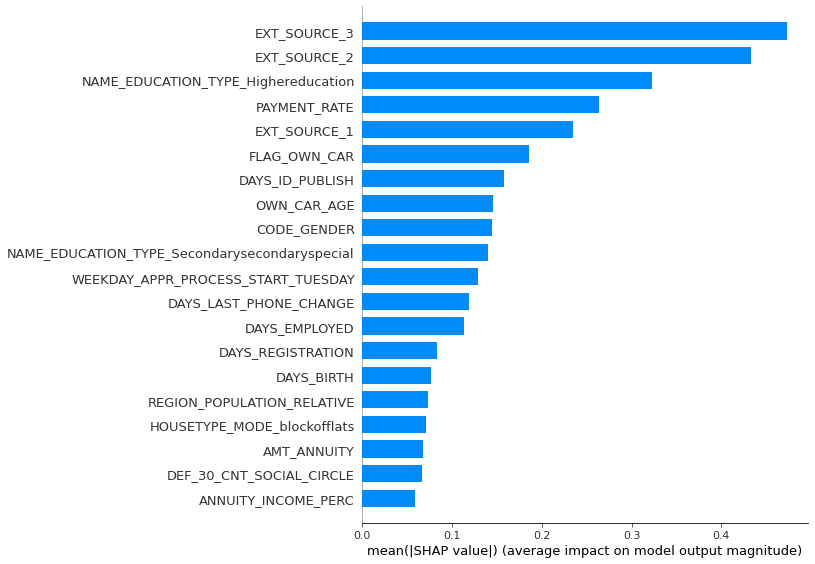

In [27]:
shap.summary_plot(shap_values[1], test_df[feats], plot_type='bar')

In [42]:
num_rows = None
df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau


prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev


pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos


ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins


cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc


df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))







Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


La partie ci-après consiste à ne garder que les 1000 premiers clients (en ID). La simple raison de ce choix est la limitation technique de chargement en mémoire de Heroku, ne permettant pas l'utilisation de l'intégralité des données.

In [48]:
df.sort_values(by=["SK_ID_CURR"], inplace=True)
df.reset_index(drop=True, inplace=True)
df_exp = df.head(1000)
df_exp.to_pickle("df.gz", compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
del df, df_exp